# This notebook shows some examples to play with MSA file.

Using `msaexp` package.

## Get summary table from `_msa.fits` file.

In [1]:
from msaexp import msa

meta = msa.MSAMetafile('jw06541001001_01_msa.fits')

src_table = meta.make_summary_table(msa_metadata_id=None,
                                  image_path=None,
                                  write_tables=False)
src_table

source_id,ra,dec,nexp,Exp1,Exp2,Exp3
int32,float64,float64,int64,str3,str3,str3
-70,53.116112,-27.782006,3,-o-,o--,--o
-69,53.115243,-27.795077,3,-o-,o--,--o
-68,53.112371,-27.827977,3,-o-,o--,--o
-67,53.115348,-27.795815,3,-o-,o--,--o
-66,53.114818,-27.801942,3,-o-,o--,--o
-65,53.112631,-27.826948,3,-o-,o--,--o
-64,53.112695,-27.832028,3,-o-,o--,--o
-63,53.113053,-27.828911,3,-o-,o--,--o
-62,53.113703,-27.823436,3,-o-,o--,--o


## Write all slits to ds9 region file from `_msa.fits` file.

In [2]:
from msaexp import msa
from pathlib import Path


meta = msa.MSAMetafile('jw06541001001_01_msa.fits')

regs = meta.regions_from_metafile(as_string=True, with_bars=True)
path = Path('jw06541001001_01_msa.reg')
path.write_text(regs)


77910

## Get ds9 region for a few targets

In [3]:
from msaexp import msa

def write_Sregion_list(sregion_list, outfile='sregion_list.reg', comment_header=None):
    '''
    Write a list of Sregion objects to a ds9 region file.
    '''
    from pathlib import Path

    output = ''
    if comment_header is not None:
        output += f'# {comment_header}\n'
    output += 'icrs\n'
    for sr in sregion_list:
        m = sr.meta
        if m['is_source']:
            output += f"circle({m['ra']:.7f}, {m['dec']:.7f}, 0.2\")"
            output += f" # color=cyan text=xx{m['source_id']}yy\n"
        for r in sr.region:
            output += r + '\n'
    output = output.replace('xx','{').replace('yy', '}')
    path = Path(outfile)
    path.write_text(output)
    return

def select_target_region(meta, target_id_list, savefile=None, with_bars=True, msa_metadata_id=1, dither_point_index=1):
    '''
    Select the regions for a given list of target id.
    '''
    regs = meta.regions_from_metafile(as_string=False, with_bars=with_bars, msa_metadata_id=msa_metadata_id, dither_point_index=dither_point_index)
    reg_target = [reg for reg in regs if reg.meta['source_id'] in target_id_list]

    if savefile is not None:
        comment_header = f'# msametfl = {meta.metafile}\n'
        di = dither_point_index
        comment_header += f'# dither_point_index = {di}\n'
        mi = msa_metadata_id
        comment_header += f'# msa_metadata_id = {mi}\n'
        target_ids_str = ','.join([str(i) for i in target_id_list])
        comment_header += f'# target_id = {target_ids_str}\n'
        write_Sregion_list(reg_target, outfile=savefile, comment_header=comment_header)

    return reg_target


meta = msa.MSAMetafile('jw06541001001_01_msa.fits')
regs = select_target_region(meta, [202892, 2023024], savefile='target_test.reg')



In [4]:
# Plot the slit region on a cutout image

from astropy.io import fits
import numpy as np
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt


with fits.open('cutout.fits') as hdulist:
    img = hdulist[0].data
    header = hdulist[0].header

ix = np.where(src_table['source_id'] == 202892)[0][0]
ra = src_table['ra'][ix]
dec = src_table['dec'][ix]
cutout_size = 2 # arcsec in radius
print(ra, dec)

hdu_crop = Cutout2D(img, position=SkyCoord(ra, dec, unit='deg'), size=2*cutout_size*u.arcsec, wcs=WCS(header))
img_crop = hdu_crop.data

53.1679177 -27.79803120000003


(-27.798586755555583, -27.797475644444475)

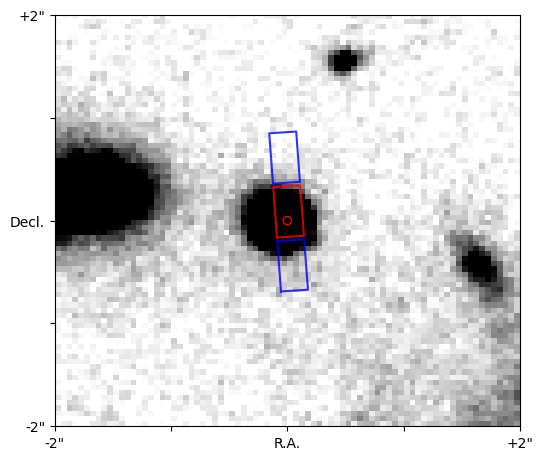

In [5]:
# Plot the slit region

cosd = np.cos(dec/180*np.pi)

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=100)

extent = (ra + cutout_size/3600/cosd, ra - cutout_size/3600./cosd,
                      dec - cutout_size/3600., dec + cutout_size/3600.)

ax.imshow(img_crop, origin='lower', cmap='gray_r', vmin=0, vmax=0.1, extent=extent)
ax.scatter(src_table['ra'], src_table['dec'], marker='o', fc='None', ec='r', alpha=1)
for s in regs:
    if s.meta['is_source']:
        kws = dict(color='r', alpha=0.8, zorder=100)
    else:
        kws = dict(color='blue', alpha=0.8, zorder=100)

    ax.plot(*np.vstack([s.xy[0], s.xy[0][:1,:]]).T, **kws)


ax.xaxis.set_major_formatter('{x:.4f}')
ax.yaxis.set_major_formatter('{x:.4f}')
step = int(np.floor(cutout_size))
xt = np.array([-step, -step/2, 0, step/2, step])/3600./cosd + ra
yt = np.array([-step, -step/2, 0, step/2, step])/3600. + dec
ax.set_xticks(xt)
ax.set_yticks(yt)
ax.set_yticklabels([f'-{step}"', '', 'Decl.', '', f'+{step}"'])
ax.set_xticklabels([f'+{step}"', '', 'R.A.', '', f'-{step}"'])
ax.set_xlim(ra + np.array([cutout_size,-cutout_size])/3600./cosd)
ax.set_ylim(dec + np.array([-cutout_size,cutout_size])/3600.)